In [1]:
import h5py as h5
import numpy as np
import matplotlib.pylab as plt
import os

In [2]:
def Div(fx,fy,T,Nx,Ny):

    Fnx = Nx
    Fny = int(Ny*0.5) + 1
    
    Ffx = np.zeros((T,Fnx,Fny), dtype=complex)
    Ffy = np.zeros((T,Fnx,Fny), dtype=complex)
    for t in range(T):
        Ffx[t,:,:] = np.fft.rfftn(fx[t,:,:])
        Ffy[t,:,:] = np.fft.rfftn(fy[t,:,:])
    
    kx = np.zeros(Fnx, dtype=int) 
    ky = np.zeros(Fny, dtype=int)
    
    for i in range(0,Fny):
        kx[i]=i
        ky[i]=i
    for i in range(Fny,Fnx):
        kx[i]=-Fnx+i   

    I=0-1j; ''' COL MENO É GIUSTO '''
    
    div = np.zeros((T,Nx,Ny))
    for t in range(T):   
        div[t,:,:] = np.fft.irfftn( (ky*Ffy[t,:,:] + np.transpose((kx*np.transpose(Ffx[t,:,:],(1,0))),(1,0))*I ))
    
    return div

In [5]:
names=[]
arr = os.listdir('.')
for i in arr:
    if(i[0:6]=='output'): 
        names.append(int(i[6:-3]))
names.sort()
tottime = names[-1]
T = len(names)
print(tottime, T)
tempi = np.linspace(0,tottime,T)
print(tempi)
for i in range(T):
    names[i] = "output" + str(names[i]) + ".h5"
print(names)

file = h5.File(names[0], "r"); d=0
for key in file.keys():
   d=d+1
   print('dataset %s = '%d,key)
Nx = int(file.attrs["NX"][0])
Ny = int(file.attrs["NY"][0])
print(Nx, Ny)
file.close()

rho = np.zeros((T,Nx,Ny))
ux = np.zeros_like(rho)
uy = np.zeros_like(rho)
for i in range(T):
    file = h5.File(names[i], "r")
    rho[i,:,:] = file.get("/rho")[...]
    ux[i,:,:] = file.get("/ux")[...]
    uy[i,:,:] = file.get("/uy")[...]
    file.close()

divV = Div(ux, uy, T, Nx, Ny)

20000 51
[    0.   400.   800.  1200.  1600.  2000.  2400.  2800.  3200.  3600.
  4000.  4400.  4800.  5200.  5600.  6000.  6400.  6800.  7200.  7600.
  8000.  8400.  8800.  9200.  9600. 10000. 10400. 10800. 11200. 11600.
 12000. 12400. 12800. 13200. 13600. 14000. 14400. 14800. 15200. 15600.
 16000. 16400. 16800. 17200. 17600. 18000. 18400. 18800. 19200. 19600.
 20000.]
['output0.h5', 'output400.h5', 'output800.h5', 'output1200.h5', 'output1600.h5', 'output2000.h5', 'output2400.h5', 'output2800.h5', 'output3200.h5', 'output3600.h5', 'output4000.h5', 'output4400.h5', 'output4800.h5', 'output5200.h5', 'output5600.h5', 'output6000.h5', 'output6400.h5', 'output6800.h5', 'output7200.h5', 'output7600.h5', 'output8000.h5', 'output8400.h5', 'output8800.h5', 'output9200.h5', 'output9600.h5', 'output10000.h5', 'output10400.h5', 'output10800.h5', 'output11200.h5', 'output11600.h5', 'output12000.h5', 'output12400.h5', 'output12800.h5', 'output13200.h5', 'output13600.h5', 'output14000.h5', 'output1

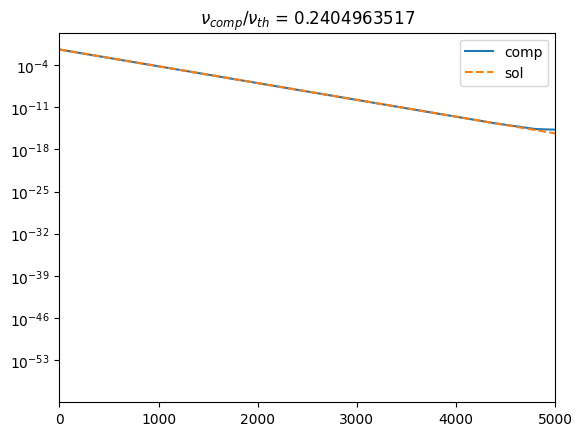

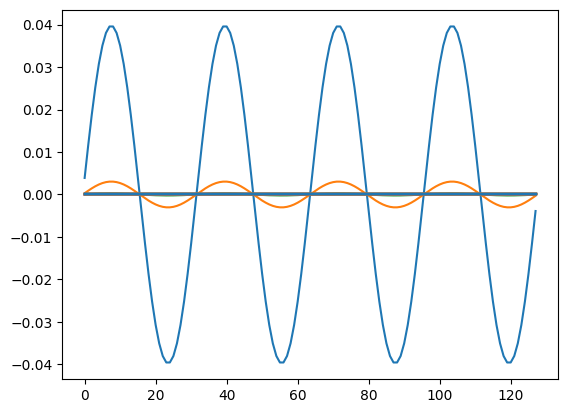

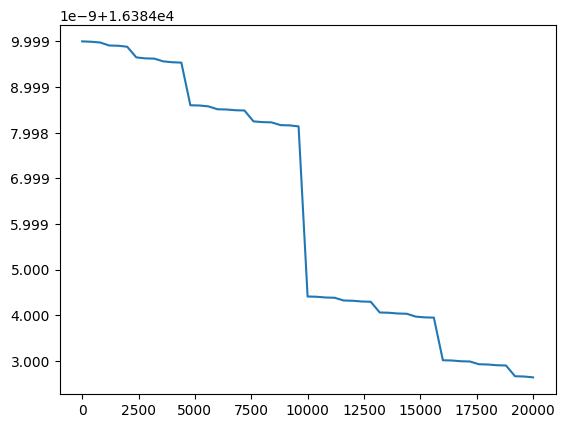

In [9]:
def plotscal(f, i):
    _ = plt.figure(i)
    _ = plt.contourf(f[i,:,:], 64)
    _ = plt.colorbar()
    _ = plt.title(names[i])

def plotfield(fx, fy, field, i):
    fac=1
    mod = fx*fx+fy*fy
    x,y = np.meshgrid(np.linspace(0,Nx-1,int(Nx/fac)),np.linspace(0,Ny-1,int(Nx/fac)))
    _ = plt.figure(i, figsize=[16,14])
    _ = plt.contourf(mod[i,:,:], 255)
    _ = plt.contourf(field[i,:,:], 255)
    _ = plt.colorbar()
    _ = plt.quiver(x,y,fx[i,::fac,::fac],fy[i,::fac,::fac], scale=2)
    _ = plt.title(names[i])

def totmass():
    M=[]
    for t in range(T):
        sum=0
        for i in range(Nx):
            for j in range(Ny):
                sum += rho[t,i,j]
        M.append(sum);
    _ = plt.figure(100)
    _ = plt.plot(tempi,M)

def check_decay(k2, vmax, th_nu, pointX, pointY):
    sol = np.zeros((T,))
    for t in range(T):
        sol[t] = vmax*np.e**(-th_nu*k2*(tempi[t]))
    plt.figure(789)
    plt.semilogy(tempi, ux[:,pointX,pointY], label='comp')
    plt.semilogy(tempi, sol, linestyle='--',label='sol')
    plt.xlim([0,5000])
    #plt.ylim([10**-3,10**-18])
    comp_nu = -(np.log(ux[0,pointX,pointY])-np.log(ux[T-1,pointX,pointY]))/(tempi[0]-tempi[T-1])/k2
    plt.legend()
    plt.title(r"$\nu_{comp}/\nu_{th}$ = %1.10f"%(comp_nu/th_nu))
    plt.figure(999)
    for t in range(T):
        plt.plot(ux[t,:,pointY])
    totmass()

mod = 8
vmax = 0.04
k2 = (mod*np.pi/128.0)**2
th_nu = 1/6
pointX = int(0.5*Nx/mod)
pointY = int(0.5*Ny/mod)
check_decay(k2, vmax, th_nu, pointX, pointY)

#for i in range(T):
    #plotscal(divV, i)
    #plotscal(rho,i)
    #plotfield(ux, uy, divV, i)
    